In [1]:
import numpy as np
import scipy

import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
    
from datetime import datetime
import time

In [28]:
class Exponenta:
    
    def __init__(self, v_0, R, M, tau, N):
        self.v_0 = v_0
        self.R = R
        self.M = M
        self.tau = tau
        self.N = N
        
        self.x = np.linspace(-R, R, M+1)
        self.delta = self.x[1] - self.x[0]
        
        # matrices
        diag_T = 2/self.delta**2 * np.ones(M-1)
        subdiag_T = -1/self.delta**2 * np.ones(M-2)
        diags_T = [subdiag_T, diag_T, subdiag_T]
        T = scipy.sparse.diags(diags_T,[-1,0,1]).toarray()
        
        I = scipy.sparse.eye(self.M-1).toarray()
        expT_pade = (I + T * self.tau / 2) @ scipy.linalg.inv(I - T * self.tau / 2)
        
        diag_V = self.v_0*np.exp(-self.x[1:-1]**2)
        diag_expV = np.exp(diag_V * self.tau / 2)
        diags_expV = [diag_expV]
        expV = scipy.sparse.diags(diags_expV,[0]).toarray()
        
        self.A = np.linalg.matrix_power(expV @ expT_pade @ expV, N)
    
    def many_E_arnoldi_iterantion(self, k):
        w, v = scipy.sparse.linalg.eigs(self.A, k=k, return_eigenvectors=True)
        
        residual = np.zeros(k)
        
        for i in range(k):
            residual[i] = scipy.linalg.norm((self.A - w[i] * scipy.sparse.eye(self.M-1).toarray()) @ v[:,i])
#         w = np.log(w.real) / (self.tau * self.N)
        
        w = np.log(np.real(w)) / (e.tau * e.N)
        
        return w[(w>self.v_0)*(w<0.0)], residual[(w>self.v_0)*(w<0.0)]

In [11]:
# constants
v_0 = -5.0
R = 6.0
M = 1000
tau = -1e-5
N = 10

e = Exponenta(v_0, R, M, tau, N)

In [12]:
e.many_E_arnoldi_iterantion(10)

array([-0.40420461, -3.14035799])

In [13]:
v_0 = -5.0
R = 6.0
m = np.linspace(100, 5000, 10, dtype=int)
tau = -1e-3
N = 10
t = [None] * len(m)

for i in range(len(m)):
    start_time = datetime.now()
    
    e = Exponenta(v_0, R, m[i], tau, N)
    w = e.many_E_arnoldi_iterantion(10)
    
    t[i] = datetime.now() - start_time
    
    print('m=', m[i], ', t=', t[i])   

m= 100 , t= 0:00:00.119344
m= 644 , t= 0:00:00.924588
m= 1188 , t= 0:00:05.305569
m= 1733 , t= 0:00:16.785795
m= 2277 , t= 0:00:37.388262
m= 2822 , t= 0:01:09.342573
m= 3366 , t= 0:01:58.797351
m= 3911 , t= 0:03:46.847344
m= 4455 , t= 0:05:08.485655
m= 5000 , t= 0:06:51.879564


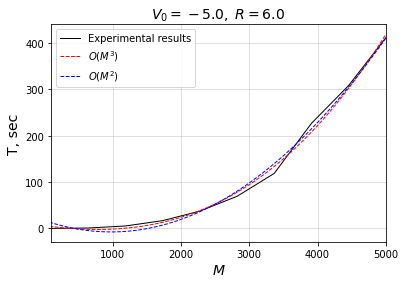

In [64]:
tt = [t_.seconds+t_.microseconds*1e-6 for t_ in t]

p3 = np.poly1d(np.polyfit(m, tt, 3))
p2 = np.poly1d(np.polyfit(m, tt, 2))
mm = np.linspace(0, m[-1])

plt.plot(m, tt, color='black', linewidth=1, label='Experimental results')

plt.plot(mm, p3(mm), color='red', linewidth=1, linestyle='--', label=r'$O(M^3)$')
plt.plot(mm, p2(mm), color='blue', linewidth=1, linestyle='--', label=r'$O(M^2)$')

plt.xlabel(r'$M$', fontsize=14)
plt.ylabel('T, sec', fontsize=14)

plt.title(fr'$V_0={v_0},\; R={R}$', fontsize=14)

plt.xlim(m[0], m[-1])
# plt.ylim(0, None)

plt.grid(alpha=0.5)
plt.legend()

plt.savefig(f'figures/T_vs_M_{e.v_0}.png', bbox_inches='tight', dpi=250)

In [49]:
v_0 = -5.0
R = 6.0
M = 1000
N = 100

tau_ = -np.logspace(-2.5, -10, 10)

E = []
residual = []

for i in range(len(tau_)):
    print(i)
    e = Exponenta(v_0, R, M, tau_[i], N)
    w, r = e.many_E_arnoldi_iterantion(10)
    E += [w[:2]]
    residual += [r[:2]]

0
1
2
3
4
5
6
7
8
9


In [50]:
E = np.array(E)
residual = np.array(residual)
E.shape, residual.shape

((10, 2), (10, 2))

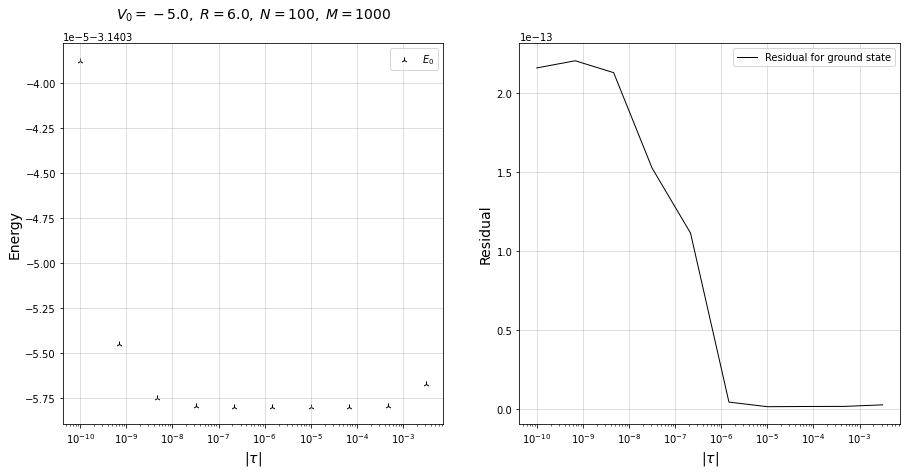

In [65]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

ax[0].scatter(abs(tau_), E[:,0], color='black', linewidth=1, label=r'$E_0$', marker='2')
ax[1].plot(abs(tau_),residual[:,0], color='black', linewidth=1, label=r'Residual for ground state')

# ax[0].axhline(y=0.0, color='black', linewidth=1, linestyle='--', label=r'Reference $E_0$')

ax[0].set_xlabel(r'$|\tau|$', fontsize=14)
ax[0].set_ylabel(r'Energy', fontsize=14)

ax[0].set_title(fr'$V_0={v_0},\; R={R},\; N={N},\; M={M}$', fontsize=14, y=1.05)

ax[0].set_xscale('log')

ax[0].grid(alpha=0.5)
ax[0].legend()

ax[1].set_xlabel(r'$|\tau|$', fontsize=14)
ax[1].set_ylabel(r'Residual', fontsize=14)

ax[1].set_xscale('log')

ax[1].grid(alpha=0.5)
ax[1].legend()

plt.savefig(f'figures/E_vs_tau_{e.v_0}_e0.png', bbox_inches='tight')

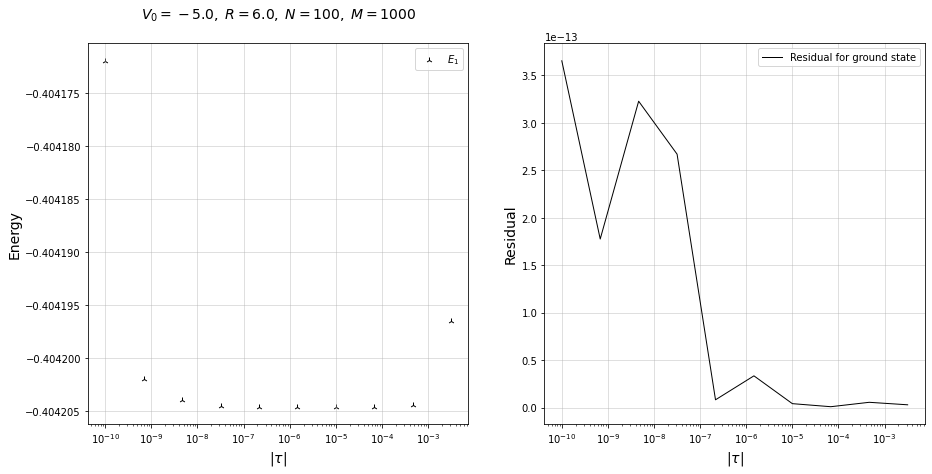

In [66]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

ax[0].scatter(abs(tau_), E[:,1], color='black', linewidth=1, label=r'$E_1$', marker='2')
ax[1].plot(abs(tau_),residual[:,1], color='black', linewidth=1, label=r'Residual for ground state')

# ax[0].axhline(y=0.0, color='black', linewidth=1, linestyle='--', label=r'Reference $E_0$')

ax[0].set_xlabel(r'$|\tau|$', fontsize=14)
ax[0].set_ylabel(r'Energy', fontsize=14)

ax[0].set_title(fr'$V_0={v_0},\; R={R},\; N={N},\; M={M}$', fontsize=14, y=1.05)

ax[0].set_xscale('log')

ax[0].grid(alpha=0.5)
ax[0].legend()

ax[1].set_xlabel(r'$|\tau|$', fontsize=14)
ax[1].set_ylabel(r'Residual', fontsize=14)

ax[1].set_xscale('log')

ax[1].grid(alpha=0.5)
ax[1].legend()

plt.savefig(f'figures/E_vs_tau_{e.v_0}_e1.png', bbox_inches='tight')